In [68]:
# !pip install bayesian-optimization

In [273]:
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
import matplotlib.pyplot as plt
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.regularizers import L2
from tensorflow.config import list_physical_devices
from bayes_opt import BayesianOptimization

In [8]:
gpus = list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


# Load Data

In [51]:
df_train = pd.read_csv("X_train_stemm_cleaned.csv")
df_valid = pd.read_csv("X_valid_stemm_cleaned.csv")
df_test = pd.read_csv("X_test_stemm_cleaned.csv")

X_train_clean = df_train['tweet_stemming']
X_valid_clean = df_valid['tweet_stemming']
X_test_clean = df_test['tweet_stemming']

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
# For SparseCategoricalCrossentropy
with open('y_train_encoded.pkl', 'rb') as file:
    y_train_encoded = pickle.load(file)

with open('y_valid_encoded.pkl', 'rb') as file:
    y_valid_encoded = pickle.load(file)

with open('y_test_encoded.pkl', 'rb') as file:
    y_test_encoded = pickle.load(file)

In [34]:
# For CategoricalCrossentropy
y_train_encoded = pd.get_dummies(y_train, dtype=float)
y_valid_encoded = pd.get_dummies(y_valid, dtype=float)
y_test_encoded = pd.get_dummies(y_test, dtype=float)

# MLP Using TF-IDF

In [4]:
# Load model TF-IDF
tfidf_vectorizer = load('tfidf_vectorizer.joblib')

# transform set data dari load model tfidf yang telah disimpan
X_train_tfidf = tfidf_vectorizer.transform(X_train_clean)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

C:\Users\andre\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\andre\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
X_train_tfidf.shape

(1270, 4216)

In [38]:
# Konversi sparse matrix ke dense array
X_train_dense = X_train_tfidf.toarray()
X_valid_dense = X_valid_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

In [7]:
# # LSTM (timesteps = 1)
# X_train_lstm = np.expand_dims(X_train_dense, axis=1)
# X_valid_lstm = np.expand_dims(X_valid_dense, axis=1)
# X_test_lstm = np.expand_dims(X_test_dense, axis=1)

## Define Model

In [59]:
# Membuat model
model = Sequential()
model.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# compile model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [60]:
# Fit model
history = model.fit(X_train_dense, y_train_encoded,
                    validation_data=(X_valid_dense, y_valid_encoded),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 1s 11ms/step - loss: 1.0990 - accuracy: 0.3205 - val_loss: 1.0978 - val_accuracy: 0.3516
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0971 - accuracy: 0.3693 - val_loss: 1.0970 - val_accuracy: 0.3956
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0949 - accuracy: 0.4283 - val_loss: 1.0959 - val_accuracy: 0.4432
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0935 - accuracy: 0.4268 - val_loss: 1.0943 - val_accuracy: 0.4579
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0887 - accuracy: 0.4953 - val_loss: 1.0923 - val_accuracy: 0.5018
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0845 - accuracy: 0.5205 - val_loss: 1.0892 - val_accuracy: 0.5092
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0782 - accuracy: 0.5520 - val_loss: 1.0847 - val_accuracy: 0.5238
Epoch 8/50
40/40 [=

<Axes: title={'center': 'Accuracy'}>

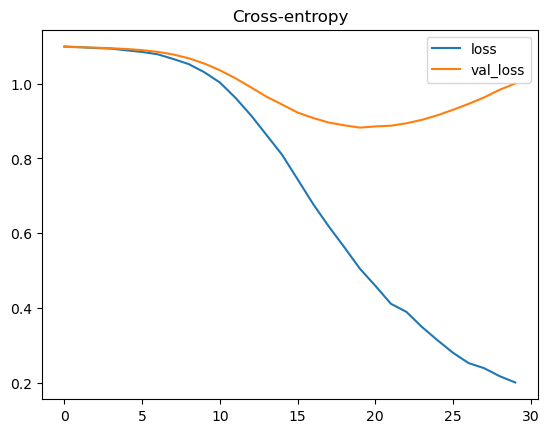

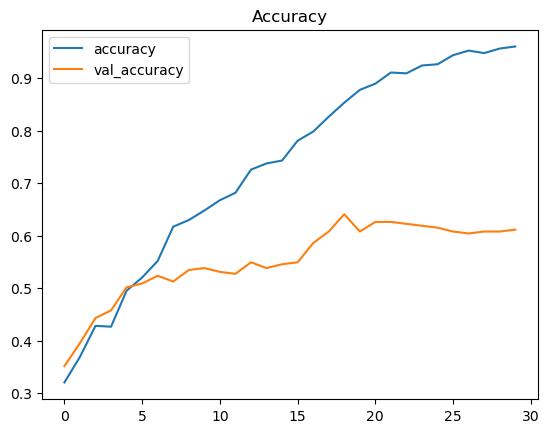

In [61]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [62]:
# evaluate model
y_pred = model.predict(X_test_dense)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     negatif       0.58      0.81      0.68        89
      netral       0.65      0.59      0.62        91
     positif       0.58      0.41      0.48        92

    accuracy                           0.60       272
   macro avg       0.61      0.61      0.59       272
weighted avg       0.61      0.60      0.59       272



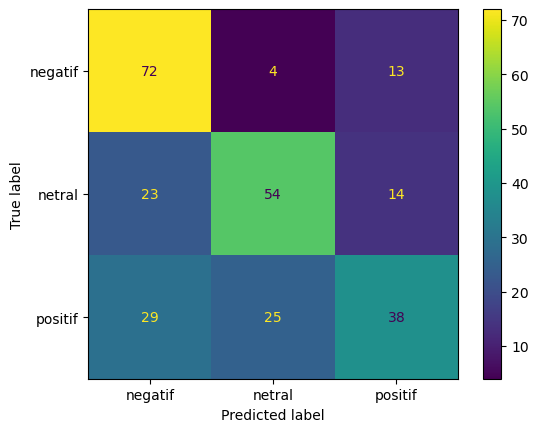

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Hyperparameter Tuning

In [70]:
# Define the neural network architecture
def create_model(learning_rate, num_hidden_layers, num_neurons):
    model = Sequential()
    for i in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
    return model

In [74]:
# Define the objective function to optimize
def objective(learning_rate, num_hidden_layers, num_neurons):
    model = create_model(learning_rate, int(num_hidden_layers), int(num_neurons))
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # Fit model
    history = model.fit(X_train_dense, y_train_encoded,
                        validation_data=(X_valid_dense, y_valid_encoded),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping])
    val_loss, val_acc = model.evaluate(X_test_dense, y_test_encoded, verbose=0)
    return val_acc

In [ ]:
    'l2': (1e-5, 1e-2)

In [76]:
# Define the search space for hyperparameters
pbounds = {'learning_rate': (0.0001, 0.001),
           'num_hidden_layers': (3, 5),
           'num_neurons': (32, 256)}

In [77]:
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | learni... | num_hi... | num_ne... |
-------------------------------------------------------------
Epoch 1/50
40/40 [==============================] - 1s 11ms/step - loss: 1.0981 - accuracy: 0.3701 - val_loss: 1.0947 - val_accuracy: 0.4359
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0824 - accuracy: 0.4732 - val_loss: 1.0669 - val_accuracy: 0.4725
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.9717 - accuracy: 0.5740 - val_loss: 0.9461 - val_accuracy: 0.5018
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.7063 - val_loss: 0.9248 - val_accuracy: 0.6007
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.4391 - accuracy: 0.8622 - val_loss: 1.0347 - val_accuracy: 0.5824
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.2711 - accuracy: 0.9236 - val_loss: 1.1460 - val_accuracy: 0.5824
Epoch 7/50
40/40 [=================

In [78]:
# Print the optimized hyperparameters and validation accuracy
print('Optimized hyperparameters:')
print(optimizer.max['params'])
print('Validation accuracy: {:.2f}%'.format(optimizer.max['target'] * 100))

Optimized hyperparameters:
{'learning_rate': 0.0002281245598513684, 'num_hidden_layers': 4.614868571403324, 'num_neurons': 61.05509623323672}
Validation accuracy: 61.40%


In [83]:
# Build model from optimized hyperparameters
model = Sequential()
model.add(Dense(64, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# compile model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [84]:
# Fit model
history = model.fit(X_train_dense, y_train_encoded,
                    validation_data=(X_valid_dense, y_valid_encoded),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 1s 11ms/step - loss: 1.0988 - accuracy: 0.3409 - val_loss: 1.0982 - val_accuracy: 0.3260
Epoch 2/50
40/40 [==============================] - 0s 7ms/step - loss: 1.0974 - accuracy: 0.3465 - val_loss: 1.0978 - val_accuracy: 0.3956
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 1.0965 - accuracy: 0.3850 - val_loss: 1.0968 - val_accuracy: 0.4615
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 1.0952 - accuracy: 0.4079 - val_loss: 1.0952 - val_accuracy: 0.4872
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 1.0907 - accuracy: 0.4465 - val_loss: 1.0912 - val_accuracy: 0.5128
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 1.0798 - accuracy: 0.5094 - val_loss: 1.0817 - val_accuracy: 0.5458
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 1.0543 - accuracy: 0.5969 - val_loss: 1.0579 - val_accuracy: 0.5714
Epoch 8/50
40/40 [=

<Axes: title={'center': 'Accuracy'}>

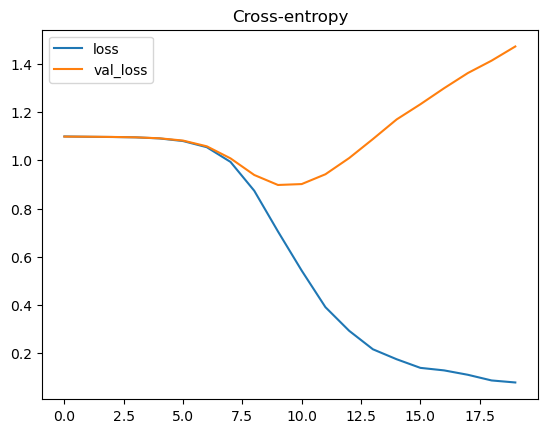

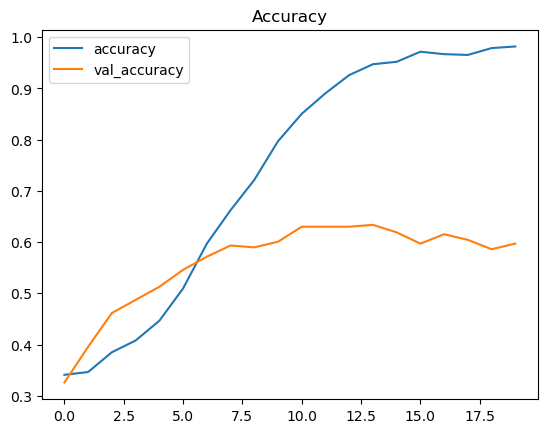

In [85]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [93]:
model.evaluate(X_test_dense, y_test_encoded, verbose=0)

[0.9076444506645203, 0.6066176295280457]

In [86]:
# evaluate model
y_pred = model.predict(X_test_dense)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     negatif       0.58      0.75      0.66        89
      netral       0.65      0.62      0.63        91
     positif       0.59      0.46      0.52        92

    accuracy                           0.61       272
   macro avg       0.61      0.61      0.60       272
weighted avg       0.61      0.61      0.60       272



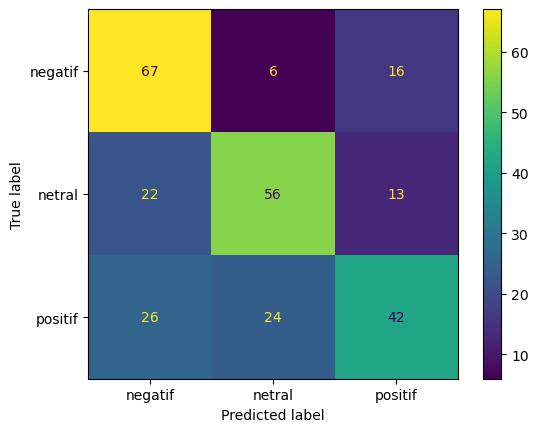

In [87]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Save Model

In [91]:
# save model
model.save_weights(
    "mlp_tuned_tfidf"
)

In [92]:
# load model
model.load_weights('mlp_tuned_tfidf')

In [ ]:
model.evaluate(X_test_dense, y_test_encoded, verbose=0)

# MLP Using skipgram

In [116]:
# load model
word2vec_model = gensim.models.word2vec.Word2Vec.load("w2v_skipgram.model")

In [122]:
max_len = 50
# tok = Tokenizer(num_words=max_words)
tok = Tokenizer()
tok.fit_on_texts(X_train_clean)
sequences_train = tok.texts_to_sequences(X_train_clean)
sequences_matrix_train = pad_sequences(sequences_train,maxlen=max_len)

sequences_valid = tok.texts_to_sequences(X_valid_clean)
sequences_matrix_valid = pad_sequences(sequences_valid,maxlen=max_len)

sequences_test = tok.texts_to_sequences(X_test_clean)
sequences_matrix_test = pad_sequences(sequences_test,maxlen=max_len)

vocab_size = len(tok.word_index) + 1
print("Total words", vocab_size)

Total words 4231


In [123]:
# WORD2VEC
W2V_SIZE = 75
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tok.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(W2V_SIZE)
print(embedding_matrix.shape)

(4231, 75)


## Define Model

In [153]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=W2V_SIZE,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # Set to False to freeze the embeddings
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# compile model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [154]:
# Fit model
history = model.fit(sequences_matrix_train, y_train_encoded,
                    validation_data=(sequences_matrix_valid, y_valid_encoded),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 1s 10ms/step - loss: 1.1096 - accuracy: 0.3299 - val_loss: 1.0969 - val_accuracy: 0.3297
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 1.0775 - accuracy: 0.3969 - val_loss: 1.0826 - val_accuracy: 0.4029
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 1.0644 - accuracy: 0.4346 - val_loss: 1.0726 - val_accuracy: 0.4029
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 1.0367 - accuracy: 0.4669 - val_loss: 1.0577 - val_accuracy: 0.4286
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 1.0112 - accuracy: 0.4992 - val_loss: 1.0465 - val_accuracy: 0.4249
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 0.9980 - accuracy: 0.5157 - val_loss: 1.0360 - val_accuracy: 0.4432
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.9890 - accuracy: 0.5220 - val_loss: 1.0259 - val_accuracy: 0.4432
Epoch 8/50
40/40 [=

<Axes: title={'center': 'Accuracy'}>

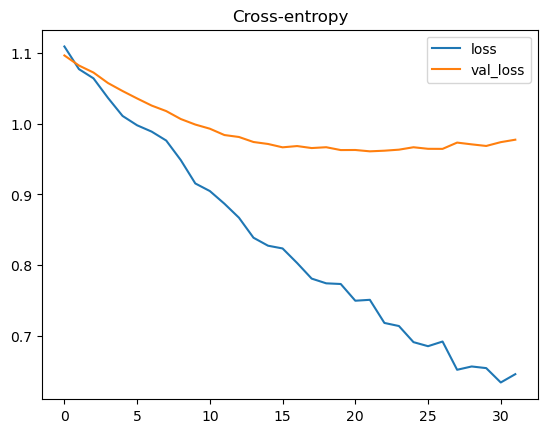

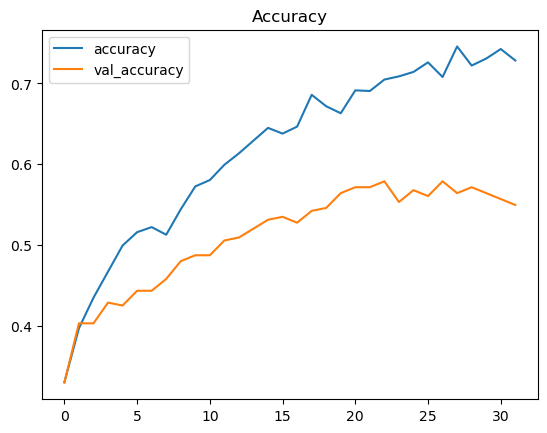

In [155]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [156]:
# evaluate model
y_pred = model.predict(sequences_matrix_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 662us/step
              precision    recall  f1-score   support

     negatif       0.58      0.55      0.56        89
      netral       0.54      0.58      0.56        91
     positif       0.53      0.51      0.52        92

    accuracy                           0.55       272
   macro avg       0.55      0.55      0.55       272
weighted avg       0.55      0.55      0.55       272



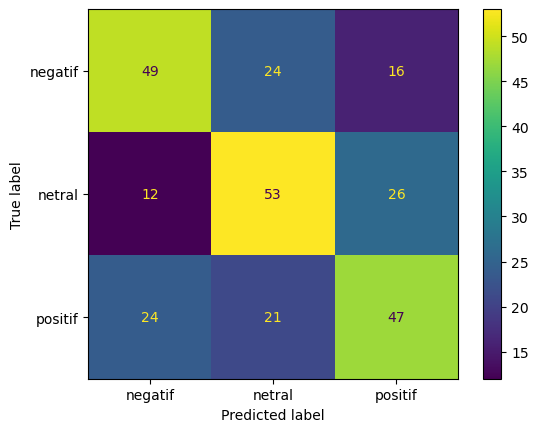

In [157]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Hyperparameter Tuning

In [159]:
# Define the neural network architecture
def create_model(learning_rate, num_hidden_layers, num_neurons):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=W2V_SIZE,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # Set to False to freeze the embeddings
    model.add(Flatten())
    model.add(Dropout(0.3))
    for i in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
    return model

In [165]:
# Define the objective function to optimize
def objective(learning_rate, num_hidden_layers, num_neurons):
    model = create_model(learning_rate, int(num_hidden_layers), int(num_neurons))
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # Fit model
    history = model.fit(sequences_matrix_train, y_train_encoded,
                    validation_data=(sequences_matrix_valid, y_valid_encoded),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping])
    val_loss, val_acc = model.evaluate(sequences_matrix_test, y_test_encoded, verbose=0)
    return val_acc

In [177]:
# Define the search space for hyperparameters
pbounds = {'learning_rate': (0.0001, 0.001),
           'num_hidden_layers': (2, 4),
           'num_neurons': (32, 256)}

In [178]:
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | learni... | num_hi... | num_ne... |
-------------------------------------------------------------
Epoch 1/50
40/40 [==============================] - 1s 10ms/step - loss: 1.0605 - accuracy: 0.4157 - val_loss: 0.9846 - val_accuracy: 0.5495
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.9275 - accuracy: 0.5591 - val_loss: 0.9594 - val_accuracy: 0.5385
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7932 - accuracy: 0.6535 - val_loss: 0.9555 - val_accuracy: 0.5421
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.6913 - val_loss: 0.9442 - val_accuracy: 0.5751
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.7323 - val_loss: 0.9842 - val_accuracy: 0.5604
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.5435 - accuracy: 0.7795 - val_loss: 1.0202 - val_accuracy: 0.5495
Epoch 7/50
40/40 [=================

In [179]:
# Print the optimized hyperparameters and validation accuracy
print('Optimized hyperparameters:')
print(optimizer.max['params'])
print('Validation accuracy: {:.2f}%'.format(optimizer.max['target'] * 100))

Optimized hyperparameters:
{'learning_rate': 0.00019229307267369907, 'num_hidden_layers': 2.3687334721667277, 'num_neurons': 167.01184556521648}
Validation accuracy: 58.82%


In [294]:
# Build model from optimized hyperparameters
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=W2V_SIZE,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # Set to False to freeze the embeddings
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(168, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(168, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# compile model
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.000192),
              metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [295]:
# Fit model
history = model.fit(sequences_matrix_train, y_train_encoded,
                    validation_data=(sequences_matrix_valid, y_valid_encoded),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 1.5523 - accuracy: 0.3551 - val_loss: 1.4868 - val_accuracy: 0.4872
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 1.4313 - accuracy: 0.4984 - val_loss: 1.4092 - val_accuracy: 0.5165
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 1.3384 - accuracy: 0.5551 - val_loss: 1.3523 - val_accuracy: 0.5128
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 1.2644 - accuracy: 0.5921 - val_loss: 1.3227 - val_accuracy: 0.5275
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 1.1949 - accuracy: 0.6181 - val_loss: 1.3025 - val_accuracy: 0.5275
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 1.1472 - accuracy: 0.6307 - val_loss: 1.2991 - val_accuracy: 0.5238
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 1.0930 - accuracy: 0.6654 - val_loss: 1.2922 - val_accuracy: 0.5238
Epoch 8/50
40/40 [==

<Axes: title={'center': 'Accuracy'}>

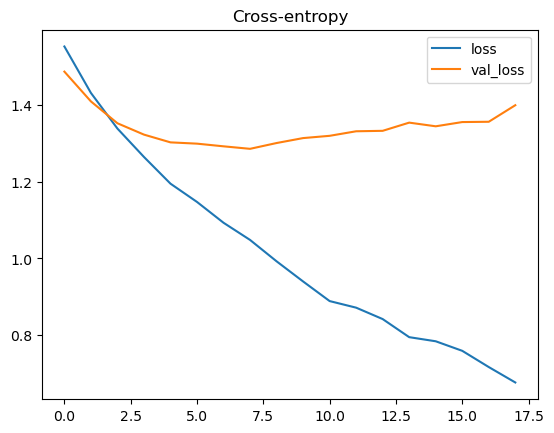

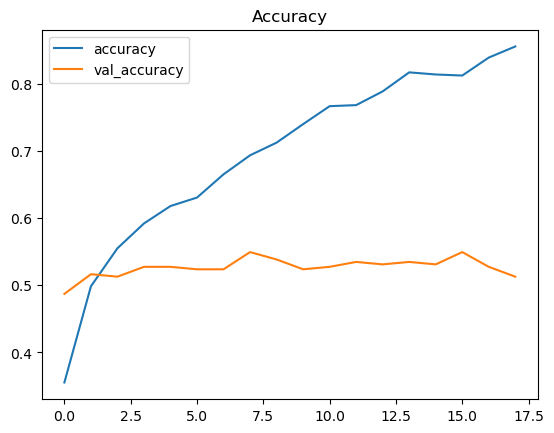

In [296]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [297]:
# evaluate model
y_pred = model.predict(sequences_matrix_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
label_ = ["negatif", "netral", "positif"]
print(classification_report(y_test_encoded.values.argmax(axis=1), y_pred_classes, target_names=label_))

9/9 [==============================] - 0s 835us/step
              precision    recall  f1-score   support

     negatif       0.55      0.63      0.59        89
      netral       0.62      0.58      0.60        91
     positif       0.56      0.51      0.53        92

    accuracy                           0.57       272
   macro avg       0.57      0.57      0.57       272
weighted avg       0.58      0.57      0.57       272



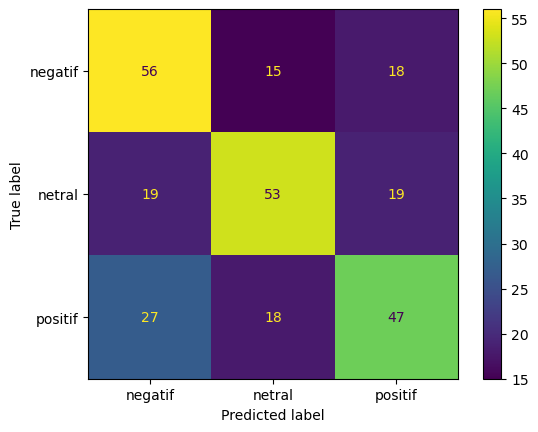

In [298]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded.values.argmax(axis=1), y_pred_classes, display_labels=label_)
plt.show()

## Save Model

In [299]:
# save model
model.save_weights(
    "mlp_tuned_word2vec"
)

In [300]:
# load model
model.load_weights('mlp_tuned_word2vec')

In [301]:
model.evaluate(sequences_matrix_test, y_test_encoded, verbose=0)

[1.296403169631958, 0.5735294222831726]